In [6]:
import sys
sys.path.append('..')

from datasets import Dataset, load_dataset

from src.dataset import to_dataloaders_for_training

DEVICE = "mps"

train_dataset: Dataset = load_dataset("tkarr/sprite_caption_dataset", split="train")
val_dataset: Dataset = load_dataset("tkarr/sprite_caption_dataset", split="valid")
train_dataloader, val_dataloader = to_dataloaders_for_training(train_dataset, val_dataset, image_pixel_size=64)

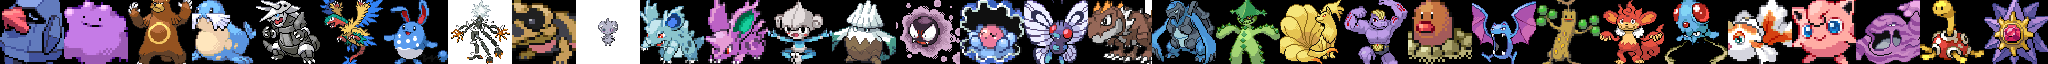

In [7]:
from IPython.display import display
from pathlib import Path

import torch

from src.utils import tensor_batch_to_pil_images, pil_image_concat

# Get the first two batches from the data loader
for batch in train_dataloader:
    input_tensor_batch: torch.Tensor = batch["tensor"].to(DEVICE)
    break

concat_images = pil_image_concat(tensor_batch_to_pil_images(input_tensor_batch))
display(concat_images)


In [9]:
from src.vae import ConvVAE_Simple

# Load the model
model = ConvVAE_Simple.load_model(Path("../checkpoints/vae-best.ckpt"), device=DEVICE)

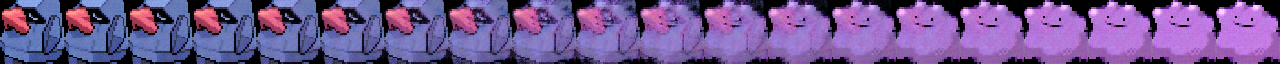

In [12]:
import torch

def interpolate_latents(
    vae_encoder: torch.nn.Module, 
    vae_decoder: torch.nn.Module, 
    img1: torch.Tensor, 
    img2: torch.Tensor, 
    steps=10, 
) -> torch.Tensor:
    mu1, _ = vae_encoder(img1.unsqueeze(0))
    mu2, _ = vae_encoder(img2.unsqueeze(0))
    # Use the mean vectors for interpolation
    z1 = mu1
    z2 = mu2
    interpolated = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        img = vae_decoder(z)
        interpolated.append(img.squeeze())
    return torch.stack(interpolated)

# Example usage
images_tensor = interpolate_latents(
    model.encode, model.decode, input_tensor_batch[0], input_tensor_batch[1], steps=20
)
display(pil_image_concat(tensor_batch_to_pil_images(images_tensor)))
